##### Experiment Ten
A quick search for a good R2

In [14]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import category_encoders as ce
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR

In [15]:
# Load dataset
df = pd.read_csv('AmazonDataSales.csv')

# MAke column names lowercase
df.columns = df.columns.str.lower()

#Drop columns with only 1 unique value:  currency, index
df.drop([ 'currency', 'index'], axis=1, inplace=True)

def fill_in_rows_with_missing_values(df):
    #Fill in missing fullfilled-by with 'unknowns-ship'
    df['fulfilled-by'] = df['fulfilled-by'].fillna('unknowns-ship')
    #Fill in missing Unnamed: 22 with 'unknown-boolean'
    df['unnamed: 22'] = df['unnamed: 22'].fillna('unknown-boolean')
    #Fill in missing promotion-ids with 'potential-id-unknown'
    df['promotion-ids'] = df['promotion-ids'].fillna('potential-id-unknown')
    #Fill in missing Courier Status with 'Unknown'
    df['courier status'] = df['courier status'].fillna('Unknown')
    #Fill in missing ship-state with 'unknown-state'
    df['ship-state'] = df['ship-state'].fillna('unknown-state')
    #Fill in missing ship-city with 'unknown-city'
    df['ship-city'] = df['ship-city'].fillna('unknown-city')
    #Fill in missing ship-postal-code with 'unknown-address'
    df['ship-postal-code'] = df['ship-postal-code'].fillna('unknown-address')
    return df

df = fill_in_rows_with_missing_values(df)

# Fix date column
df['date'] = pd.to_datetime(df['date'], format='%m-%d-%y', errors='coerce')

#drop all rows with missing values 
df.dropna(inplace=True)

# Feature engineering function
def feature_eng_function(df):

    # Drop rows with 'courier status' = "cancelled"
    df = df[df['courier status'] != 'cancelled']
    # Drop rows with 'status' = "cancelled"
    df = df[df['status'] != 'cancelled']
    #Drop rows with 'qty' = 0
    df = df[df['qty'] != 0]
    #Drop rows with 'amount' = 0
    df = df[df['amount'] != 0]
    # Drop all columns except 'amount', 'asin', 'sku', size, style
    df = df[['amount', 'size', 'qty', 'category','style']] # What adding style does!

    return df

# Not using feature engineering for the experiment
#df = feature_eng_function(df)


# Select all columns except 'amount' as feature columns
feature_columns = df.columns.drop('amount')
# binary encode the feature columns
encoder = ce.BinaryEncoder(cols=feature_columns)
df_encoded = encoder.fit_transform(df[feature_columns])

X = df_encoded  # Features
y = df['amount']  # Target

C:\Users\Tono\AppData\Local\Temp\ipykernel_17420\1627465663.py:2: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('AmazonDataSales.csv')


In [16]:
#Count the number of feature columns
num_feature_columns = len(df_encoded.columns)
print(f"Number of feature columns: {num_feature_columns}")

Number of feature columns: 138


In [17]:
# Processing for NN
# Convert to numpy arrays (required for PyTorch tensors)
X_np = np.array(X, dtype=np.float32)
y_np = np.array(y, dtype=np.float32)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_np)
y_tensor = torch.tensor(y_np)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Create TensorDatasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [18]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [19]:
# Define the Transformer model
class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, num_heads, ff_dim, num_transformer_blocks, output_dim, dropout_rate=0.1):
        super(TransformerRegressor, self).__init__()
        # Define the transformer blocks with dropout
        self.transformer_blocks = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads, 
                                       dim_feedforward=ff_dim, dropout=dropout_rate)
            for _ in range(num_transformer_blocks)
        ])
        # Optional: Add dropout before the final linear layer
        self.dropout = nn.Dropout(dropout_rate)
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        # Reshape input for transformer: [sequence_length, batch_size, feature_size]
        x = x.transpose(0, 1)  # Swap batch_size and sequence_length dimensions
        for transformer in self.transformer_blocks:
            x = transformer(x)
        x = x.transpose(0, 1)  # Swap back the dimensions
        # Apply dropout before the final linear layer
        x = self.dropout(x[:, 0, :])  
        return self.linear(x).view(-1, 1)  # Reshape output to [batch_size, 1]

# Model instantiation
model = TransformerRegressor(
    input_dim=X_train.shape[1], 
    num_heads=3, 
    ff_dim=64, 
    num_transformer_blocks=2, 
    output_dim=1,
).to(device)

In [35]:
# Learning rate scheduler function
def learning_rate(epoch, total_epochs):
    if epoch < total_epochs / 4:
        lr = 0.001 * (epoch / (total_epochs / 4))
    elif epoch < total_epochs * (3 / 4):
        lr = 0.001
    else:
        # Calculate the remaining fraction of epochs and use it to linearly interpolate between 0.001 and 0.0005.
        remaining_epochs = epoch - total_epochs * (3 / 4)
        total_decreasing_epochs = total_epochs - total_epochs * (3 / 4)
        lr = 0.001 - (0.0005 * (remaining_epochs / total_decreasing_epochs))
    return lr

# Initialize optimizer with a nominal learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Nominal LR, will be adjusted by scheduler

total_epochs = 200  # Define your total number of epochs here

# Define the loss function
criterion = nn.MSELoss()

In [48]:
# Training function
# Adjusted training function to emphasize scheduler's role
def train_model(model, train_loader, criterion, optimizer, total_epochs):
    model.train()
    for epoch in range(total_epochs):
        total_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs.unsqueeze(1))
            targets = targets.view(-1, 1)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            for param_group in optimizer.param_groups:
                param_group['lr'] = learning_rate(epoch, total_epochs)  # Update the learning rate
        # Print the current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch {epoch+1}/{total_epochs}, Loss: {total_loss/len(train_loader)}, LR: {current_lr}')

In [29]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    targets_list = []
    outputs_list = []
    with torch.no_grad():
        total_loss = 0
        for inputs, targets in test_loader:
            # Move data to the device
            inputs, targets = inputs.to(device), targets.to(device)
            #
            outputs = model(inputs.unsqueeze(1))
            targets = targets.view(-1, 1)  # Ensure targets are the correct shape
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            targets_list.append(targets.cpu())  # Move targets back to CPU
            outputs_list.append(outputs.cpu())  # Move outputs back to CPU
        
        # Concatenate all batches
        all_targets = torch.cat(targets_list, dim=0)
        all_outputs = torch.cat(outputs_list, dim=0)

        # Calculate R-squared score
        r2 = r2_score(all_targets.numpy(), all_outputs.numpy())
        
        print(f'Test Loss: {total_loss/len(test_loader)}')
        print(f'R-squared: {r2}')

In [ ]:
print(f"Input feature size: {X_train.shape[1]}")

In [49]:
# Hit it again! 200 go!
num_epochs = total_epochs
train_model(model, train_loader, criterion, optimizer, num_epochs)

Epoch 1/200, Loss: 11441.534868627865, LR: 0.0
Epoch 2/200, Loss: 11274.100018423276, LR: 2e-05
Epoch 3/200, Loss: 10847.581803535722, LR: 4e-05
Epoch 4/200, Loss: 10815.557928321858, LR: 6e-05
Epoch 5/200, Loss: 10689.663805475964, LR: 8e-05
Epoch 6/200, Loss: 10726.220361070456, LR: 0.0001
Epoch 7/200, Loss: 10660.610235289721, LR: 0.00012
Epoch 8/200, Loss: 10580.606197628937, LR: 0.00014000000000000001
Epoch 9/200, Loss: 10707.578186518283, LR: 0.00016
Epoch 10/200, Loss: 10724.96814222512, LR: 0.00017999999999999998
Epoch 11/200, Loss: 10591.070071258142, LR: 0.0002
Epoch 12/200, Loss: 10578.234819477655, LR: 0.00022
Epoch 13/200, Loss: 10602.752695692561, LR: 0.00024
Epoch 14/200, Loss: 10632.876254199991, LR: 0.00026000000000000003
Epoch 15/200, Loss: 10619.098237291804, LR: 0.00028000000000000003
Epoch 16/200, Loss: 10571.021134268325, LR: 0.0003
Epoch 17/200, Loss: 10577.734770198611, LR: 0.00032
Epoch 18/200, Loss: 10740.90663038269, LR: 0.00034
Epoch 19/200, Loss: 10591.2944

In [50]:
# and evaluation
evaluate_model(model, test_loader)

Test Loss: 12462.13372866982
R-squared: 0.8416707480102197


*********************
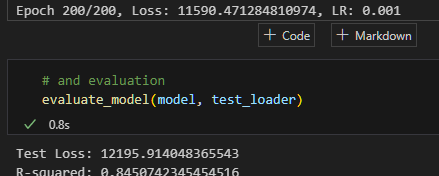    
*************    
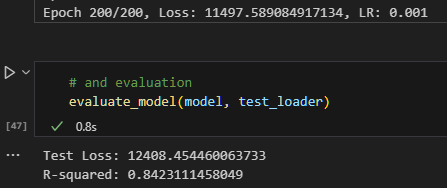   
********************   
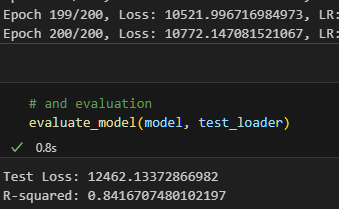   
It's interesting to see the training loss keep decreasing but the test R2 gets slightly worse
